# Download a BioCam data set
This recording from a mouse retina was done by [Gerrit Hilgen](https://www.ncl.ac.uk/ion/staff/profile/gerrithilgen.html#background) at ION, Newcastle University, in the lab of [Evelyne Sernagor](https://www.ncl.ac.uk/ion/staff/profile/evelynesernagor.html#background). Note not the full array was recorded here (4,096 channels), but only a subset of 1056 channels, at 17kHz.

In [2]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

print('Downloading data file - around 8GB, so this may take a while, patience...')
password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "ovUz70bzg5pAM5Z", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('biocam_data.brw', 'wb') as out_file:
    data = response.read()
    out_file.write(data)
print('...done')

t
...done


# Use of the `HSDetection` class

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('..')
from hs2 import HSDetection
from probe import BioCam
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# raw data location
data_path = 'biocam_data.brw'

# detection parameters
to_localize = True
cutout_start = 10
cutout_end = 30
threshold = 16
file_directory = 'results/'
file_name = 'ProcessedSpikes_biocam.bin'

In [3]:
Probe = BioCam(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name,
                file_directory_name=file_directory)

# 3Brain data format: 101 signal inversion 1.0
#       signal range:  -4125.0 -  4125.0
# Signal inversion looks like 1.0 , guessing the right method for data access.
# If your detection results look strange, signal polarity is wrong.
# With 3Brain you never know when they swap it next :)
# Note: only 1056 channels recorded, fixing positions/neighbors
# This may break - known to work only for rectangular sections!
#  31 63 0 31 33 32 1056


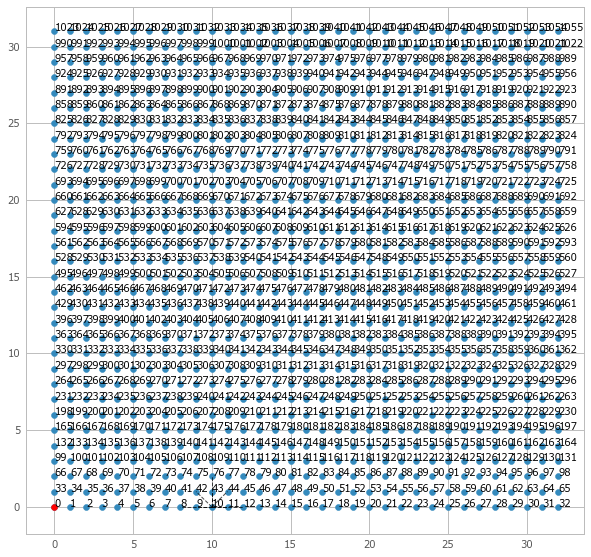

In [8]:
Probe.show(figwidth=10)

In [21]:
H.DetectFromRaw()

# Sampling rate: 17251
# Localization On
# Masking Channels: [0]
# Number of recorded channels: 1056
# Analysing frames: 4140363, Seconds:239.99994605836005
# Frames before spike in cutout: 17
# Frames after spike in cutout: 37
# tcuts: 29 42
# tInc: 50000
# Analysing 50000 frames; from -29 to 50042
# t0:50000 tcut2:42 tInc:50000
# Analysing 50000 frames; from 49971 to 100042
# t0:100000 tcut2:42 tInc:50000
# Analysing 50000 frames; from 99971 to 150042
# t0:150000 tcut2:42 tInc:50000
# Analysing 50000 frames; from 149971 to 200042
# t0:200000 tcut2:42 tInc:50000
# Analysing 50000 frames; from 199971 to 250042
# t0:250000 tcut2:42 tInc:50000
# Analysing 50000 frames; from 249971 to 300042
# t0:300000 tcut2:42 tInc:50000
# Analysing 50000 frames; from 299971 to 350042
# t0:350000 tcut2:42 tInc:50000
# Analysing 50000 frames; from 349971 to 400042
# t0:400000 tcut2:42 tInc:50000
# Analysing 50000 frames; from 399971 to 450042
# t0:450000 tcut2:42 tInc:50000
# Analysing 50000 frames; from

In [4]:
H.LoadDetected()

Detected and read 36235 spikes.


Spike detected at channel:  86
Spike detected at frame:  172068
20.365 1.602


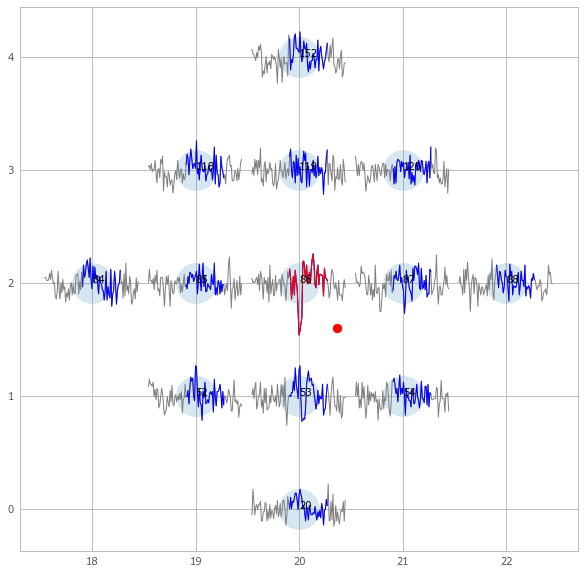

In [23]:
plt.figure(figsize=(10, 10))
H.PlotTracesChannels(1000, window_size=100)

(-1.5488820788530469,
 32.52388207885305,
 -1.4974147167034584,
 33.53241471670346)

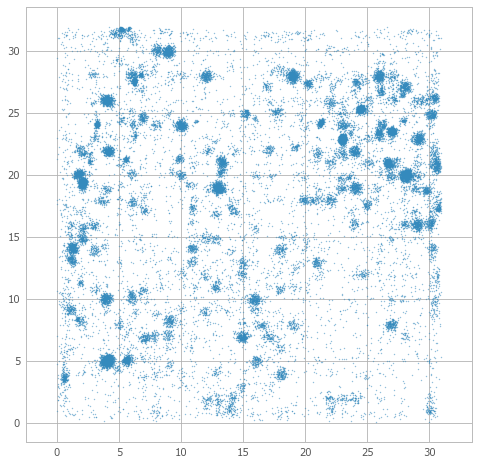

In [24]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
H.PlotAll(invert=True, s=1, alpha=0.4, ax=ax)
plt.axis('equal')

# Use of the `HSClustering` class

In [5]:
from hs2 import HSClustering

In [6]:
# Load from file
#C = Clustering(['ProcessedSpikes_biocam.bin', 'ProcessedSpikes_biocam.bin'], cutout_length=41)

# Or if the spikes are already in memory
# simply load from the Detection class
C = HSClustering(H)

In [7]:
%%time
C.ShapePCA(pca_ncomponents=2, pca_whiten=True)

Fitting PCA using 36235 spikes...
CPU times: user 632 ms, sys: 80.5 ms, total: 713 ms
Wall time: 166 ms


array([[-0.52191975,  0.63059355],
       [-0.52796483,  0.3874492 ],
       [ 1.34308526, -0.86822594],
       ...,
       [-0.83411963,  0.83622185],
       [-0.33905257,  0.10638171],
       [-0.7914979 ,  0.18741372]])

In [8]:
%%time
C.CombinedClustering(alpha=0.3, bandwidth=0.3, bin_seeding=False, n_jobs=-1)

Clustering...
Clustering 36235 spikes...
number of seeds: 36235
seeds/job: 3020
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   14.4s remaining:   43.2s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   15.0s remaining:    3.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   15.4s finished


Number of estimated clusters: 3563
CPU times: user 6.12 s, sys: 79.6 ms, total: 6.2 s
Wall time: 21.1 s


(-1.5488820788530469,
 32.52388207885305,
 -1.4974147167034584,
 33.53241471670346)

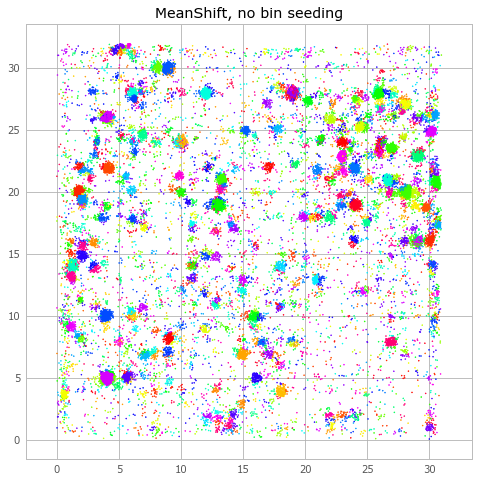

In [31]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
C.PlotAll(invert=True, s=1, ax=ax, max_show=100000,show_labels=False)
plt.title("MeanShift, no bin seeding");
plt.axis('equal')

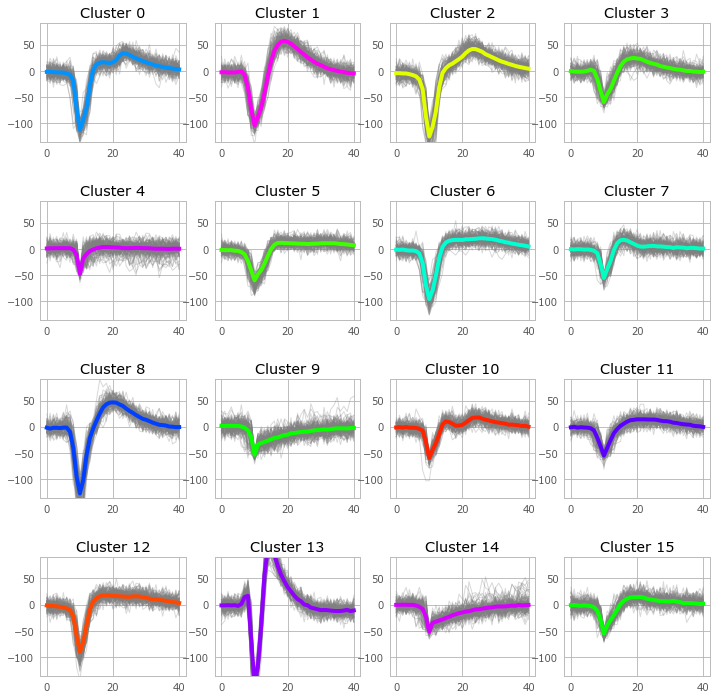

In [32]:
units = range(16)
C.PlotShapes(units)

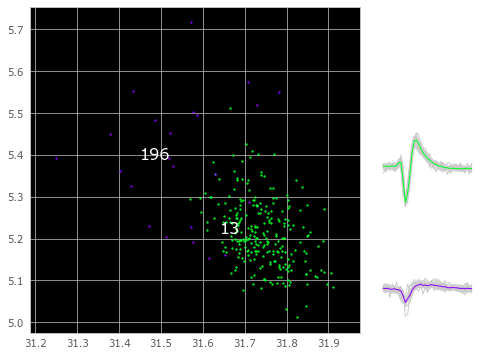

In [16]:
C.PlotNeighbourhood(13,radius=0.4, alpha=0.9);

In [ ]:
C.SaveHDF5(file_name+"_sorted.hdf5")